# Variable dz water balance

The purpose of this script is to be able to monitor a run's progress and view how the water balance is progressing (for example during spinup). It should take into consideration variable dz adjustments

In [1]:
from postproc import scale_pfb
import numpy as np

import subprocess
import glob
import os
import shutil
import time
import pandas as pd
from io import StringIO

%matplotlib inline

In [2]:
cur_stop = 98

In [3]:
def silo2pfb(bnam, start, stop):
    '''
    Converts a timeseries of silo output to pfb format
    (saves converted pfbs to same directory)
    
    '''
    bashCommand = "tclsh silotopfb_iter_bnam.tcl %s %s %s" %(bnam,start,stop)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    print(output)
    print(error)

def sumoverdomain(bnam, start, stop):
    '''
    Sums over the entire domain for an input pfb file,
    returns a dataframe with columns for t and the sum values
    
    bnam    the base name of the files to sum
    start   the start number of file indexing
    end     the end number of file indexing
    '''
    bashCommand = "tclsh sum_domain_bnam.tcl %s %s %s" %(bnam,start,stop)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

    # Save the output to a dataframe
    output = output.decode("utf-8").format()
    df = pd.read_csv(StringIO(output), sep="\t", header = None)
    df.columns = ['t','sum_val']  # add a header (column name)
    
    # return
    return(df)
    

# Apply scale factors for vdz

The scaling factors need to be applied for subsurface storage, and potentially to surface storage and surface runoff as well.

- Need a silotopfb_iter.tcl script that can be applied to various files' base names

In [4]:
factors = np.array([[2.0],  # <- bottom
                    [2.0],
                    [2.0],
                    [1.0],
                    [1.0],
                    [1.0],
                    [0.25],
                    [0.25],
                    [0.25],
                    [0.25]]) # <- top

## Overland Flow 
Overland flow does not need scale factors applied

In [5]:
silo2pfb(bnam ='surface_runoff' , start=1, stop=cur_stop)
of = sumoverdomain(bnam = 'surface_runoff',start = 1, stop= cur_stop)
of.head(10)

b''
None


,t,sum_val
0,1,0.000000
1,2,0.000000
2,3,62.381299
3,4,666.453644
4,5,667.003334
5,6,667.481108
6,7,667.902669
7,8,668.278188
8,9,668.615443
9,10,668.920495


## Surface Storage 
Surface storage does not need scale factors applied

In [6]:
silo2pfb(bnam ='surface_storage' , start= 0, stop=cur_stop)
s = sumoverdomain(bnam = 'surface_storage',start = 0, stop= cur_stop)
s.head(10)

b''
None


,t,sum_val
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,3582.233512
4,4,14838.268322
5,5,14845.610271
6,6,14851.989691
7,7,14857.617017
8,8,14862.628550
9,9,14867.128467


## Subsurface storage

In [7]:
# convert silos to pfbs
silo2pfb(bnam ='subsurface_storage' , start= 0, stop=cur_stop)

# scale pfbs using factors
for i in range(0,cur_stop+1):
    infnam = 'subsurface_storage.%s.pfb' %i
    outfnam = 'vdz_subsurface_storage.%s.pfb' %i
    
    scale_pfb(pfbinfnam = infnam, vdzarr = factors, pfboutfnam = outfnam, 
         nx = 12, ny = 10, dx = 10, dy = 10, dz = 1)
    
ss = sumoverdomain(bnam = 'vdz_subsurface_storage',start = 0, stop= cur_stop)
ss.head(10)

b''
None


,t,sum_val
0,0,2.870042e+06
1,1,2.930042e+06
2,2,2.990042e+06
3,3,3.046460e+06
4,4,3.091621e+06
5,5,3.136776e+06
6,6,3.181924e+06
7,7,3.227066e+06
8,8,3.272204e+06
9,9,3.317336e+06


# Water balance

**NOTE** This will not balance if the run was executed with overland flow keys on! Water will begin to be "lost" from the domain when overland flow occurs.

In [8]:
wb = ss.merge(of, on = 't', how = 'left').merge(s, on = 't', how = 'left')
wb.fillna(0, inplace=True)
wb.columns = ['t', 'vdz_subsurfstor', 'overland_flow', 'surf_stor']
wb['dom_tot'] = wb['vdz_subsurfstor'] +  wb['overland_flow'] +  wb['surf_stor'] 
wb

,t,vdz_subsurfstor,overland_flow,surf_stor,dom_tot
0,0,2.870042e+06,0.000000,0.000000,2.870042e+06
1,1,2.930042e+06,0.000000,0.000000,2.930042e+06
2,2,2.990042e+06,0.000000,0.000000,2.990042e+06
3,3,3.046460e+06,62.381299,3582.233512,3.050104e+06
4,4,3.091621e+06,666.453644,14838.268322,3.107126e+06
5,5,3.136776e+06,667.003334,14845.610271,3.152288e+06
6,6,3.181924e+06,667.481108,14851.989691,3.197443e+06
7,7,3.227066e+06,667.902669,14857.617017,3.242592e+06
8,8,3.272204e+06,668.278188,14862.628550,3.287735e+06
9,9,3.317336e+06,668.615443,14867.128467,3.332872e+06


In [9]:
wb['dom_tot'].diff()

0              NaN
1     60000.000000
2     60000.000000
3     60062.381299
4     57021.838833
5     45162.281369
6     45154.867503
7     45148.431869
8     45142.758502
9     45137.708705
10    45133.176585
11    45129.079732
12    45125.352944
13    45121.943874
14    45118.809956
15    45115.916180
16    45113.233450
17    45110.737367
18    45108.407294
19    45106.225648
20    56923.585887
21    21464.374774
22      356.930192
23      347.502758
24      344.090314
25      341.156735
26      338.381639
27      335.727470
28      333.183227
29      330.741065
          ...     
69      275.449272
70      274.625508
71      273.816764
72      273.022588
73      272.242549
74      271.476233
75      270.723243
76      269.983199
77      269.255736
78      268.540504
79      267.837166
80      267.145398
81      266.464888
82      265.795338
83      265.136363
84      264.487661
85      263.848955
86      263.219979
87      262.600476
88      261.990200
89      261.388912
90      260.

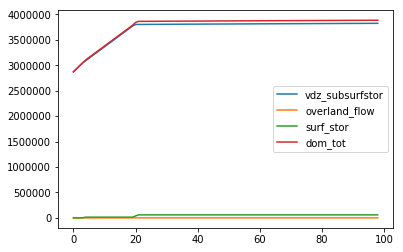

In [10]:
wb[['vdz_subsurfstor', 'overland_flow', 'surf_stor', 'dom_tot']].plot.line()

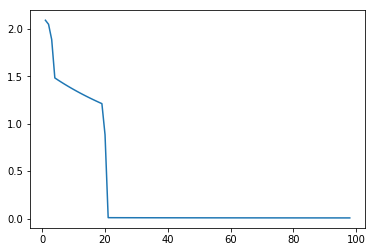

In [16]:
pc_change = wb['vdz_subsurfstor'].pct_change()*100
pc_change.plot.line()